# Process Hipster dataset using VariantSpark and Logistic Regression

# ======================================================

# Path to input file and number of CPU

In [1]:
INPUT='data/Hipster.100K.vds'
numCPU=16
numPartition=numCPU*3

# Some Initialisation

In [2]:
%%juspark --profile hail
{"spark.driver.memory":"8G"}


PySpark initialised: spark context available as sc


In [3]:
import hail
import varspark.hail

In [4]:
hc = hail.HailContext(sc)

Running on Apache Spark version 2.2.1
SparkUI available at http://ip-172-31-22-87.ap-southeast-2.compute.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-20613ed


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import log, isnan
from pprint import pprint
from decimal import Decimal
from pyspark.sql.functions import *
from datetime import datetime
from hail import KeyTable
from hail.keytable import asc
from hail.keytable import desc

In [6]:
ofs = [
    0,
    0,         # offset for chr1
    249250621, # offset for chr2
    492449994, # offset for chr3
    690472424,
    881626700,
    1062541960,
    1233657027,
    1392795690,
    1539159712,
    1680373143,
    1815907890,
    1950914406,
    2084766301,
    2199936179,
    2307285719,
    2409817111,
    2500171864,
    2581367074,
    2659444322,
    2722469842,
    2781598825,
    2832903391
]


def ColorImportant(pd):
    pd['c'] = "silver"
    pd.loc[pd['chr'] == '1', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '3', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '5', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '7', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '9', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '11', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '13', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '15', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '17', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '19', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '21', 'c'] = "lightgrey"
    
    pd.loc[pd['jk'] == '2_223034082', 'c'] = "black"  #B6
    pd.loc[pd['jk'] == '4_54511913' , 'c'] = "red"   #B2
    pd.loc[pd['jk'] == '5_126626044', 'c'] = "green" #R1
    pd.loc[pd['jk'] == '7_17284577'  , 'c'] = "blue" #C2
    
    pd['Important'] = False
    
    pd.loc[pd['jk'] == '2_223034082', 'Important'] = True #B6
    pd.loc[pd['jk'] == '4_54511913' , 'Important'] = True #B2
    pd.loc[pd['jk'] == '5_126626044', 'Important'] = True #R1
    pd.loc[pd['jk'] == '7_17284577' , 'Important'] = True #C2
    return pd

def Manhattan(pdf, key, text):
    pdf['xpos'] = pdf.apply(lambda row: ofs[int(row['chr'])] + row['pos'], axis=1)
    pdf = ColorImportant(pdf)
    pdf2 = pdf.loc[pdf['Important'] == True]
    
    plt.figure(figsize=(15,10))
    plt.scatter(pdf['xpos'], pdf[key], c = pdf['c'])
    plt.scatter(pdf2['xpos'], pdf2[key], c = pdf2['c'])
    plt.xlim(pdf['xpos'].min(), pdf['xpos'].max())
    plt.ylim(0, pdf[key].max()*1.1)
    plt.xlabel("chromosomes")
    plt.ylabel(text)
    plt.title("Manhattan Plot of "+ text)
    #legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
    #plt.legend(handles=legend_entries, loc=2)
    plt.show()

In [7]:
%matplotlib inline

In [8]:
nb_begin = datetime.now()

# Load Genomic Data (VDS format)

In [9]:
caseCtrlVds = hc.read(INPUT)\
.repartition(numPartition)\
.cache()

# Count number of samples and variants (features)

In [10]:
cnt=caseCtrlVds.count()

In [11]:
print('Number of Samples', cnt[0])
print('Number of Variants', cnt[1])

('Number of Samples', 2504L)
('Number of Variants', 100440L)


# Print sample annotation schema

In [12]:
pprint(caseCtrlVds.sample_schema)

Struct{
     pheno: Struct{
         B6: Int,
         R1: Int,
         B2: Int,
         C2: Int,
         Score: Int,
         `Score+Noise`: Double,
         Hipster: Int,
         Noise: Double,
         isCase: Boolean,
         population: String
     },
     pca: Struct{
         PC1: Double,
         PC2: Double
     }
 }


# Print variants annotation schema

In [13]:
pprint(caseCtrlVds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     info: Struct{
         CIEND: Array[Int],
         CIPOS: Array[Int],
         CS: String,
         END: Int,
         IMPRECISE: Boolean,
         MC: Array[String],
         MEINFO: Array[String],
         MEND: Int,
         MLEN: Int,
         MSTART: Int,
         SVLEN: Array[Int],
         SVTYPE: String,
         TSD: String,
         AC: Array[Int],
         AF: Array[Double],
         NS: Int,
         AN: Int,
         EAS_AF: Array[Double],
         EUR_AF: Array[Double],
         AFR_AF: Array[Double],
         AMR_AF: Array[Double],
         SAS_AF: Array[Double],
         DP: Int,
         AA: String,
         VT: Array[String],
         EX_TARGET: Boolean,
         MULTI_ALLELIC: Boolean
     }
 }


# Plot pre-computed PCA values

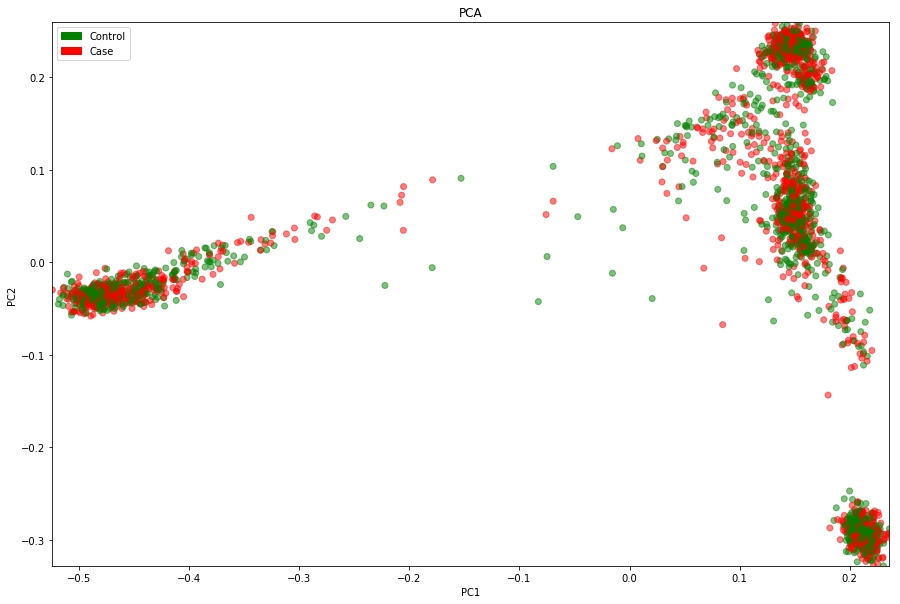

In [14]:
pca_table = caseCtrlVds.samples_table().to_pandas()
colors = {'Control': 'green', 'Case': 'red'}
plt.figure(figsize=(15,10))
plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"],
            c = pca_table["sa.pheno.population"].map(colors),
            alpha = .5)
plt.xlim(pca_table["sa.pca.PC1"].min(), pca_table["sa.pca.PC1"].max())
plt.ylim(pca_table["sa.pca.PC2"].min(), pca_table["sa.pca.PC2"].max())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()


# Logestic Regression Analysis

In [15]:
begin = datetime.now()
caseCtrlVds = caseCtrlVds\
.logreg(test='wald' , root='va.wald' , y='sa.pheno.isCase', covariates=['sa.pca.PC1', 'sa.pca.PC2'])
caseCtrlVds.count()
end = datetime.now()
print('Runtime: '+str(end-begin))

2019-02-27 05:06:33 Hail: INFO: Running wald logistic regression on 2504 samples with 3 covariates including intercept...


Runtime: 0:00:21.154956


# VariantSpark Analysis (100 trees)

In [16]:
begin = datetime.now()
via = caseCtrlVds.importance_analysis("sa.pheno.Hipster", n_trees = 100, mtry_fraction = 0.1, oob = False, seed = 13L,  batch_size = 20)
iv = via.important_variants(1000000);
caseCtrlVds = caseCtrlVds.annotate_variants_table(iv, root='va.vsis')
caseCtrlVds.count()
end = datetime.now()
print('Runtime: '+str(end-begin))

2019-02-27 05:08:23 Hail: INFO: Ordering unsorted dataset with network shuffle


Runtime: 0:01:43.506136


# Compute ranks and -log10(p-value)

In [17]:
vt = caseCtrlVds.variants_table().flatten()
vt = vt.order_by(desc('va.vsis')).indexed('vs')
vt = vt.order_by(asc('va.wald.pval')).indexed('wald')
vt = vt.annotate('wald_log10=-log10(`va.wald.pval`)')
vt = vt.select((['v', 'vs', 'wald', 'wald_log10']))
vt = vt.key_by('v')
caseCtrlVds = caseCtrlVds.annotate_variants_table(vt, root='va.rank')

2019-02-27 05:09:18 Hail: INFO: Ordering unsorted dataset with network shuffle


# Take top 1000 variants for each analysis

### we make sure to include 4 important variants too

In [18]:
intervals = map(hail.representation.Interval.parse,\
['2:223034081-223034083', '5:126626043-126626045', '4:54511912-54511914', "7:17284576-17284578"])
Important_var = caseCtrlVds.filter_intervals(intervals)

top_vs   = caseCtrlVds.filter_variants_expr('va.rank.vs   < 1000').union(Important_var).deduplicate()
top_wald = caseCtrlVds.filter_variants_expr('va.rank.wald < 1000').union(Important_var).deduplicate()

pd_wald = top_wald.variants_table().expand_types().flatten().rename({'v.contig':'chr'}).rename({'v.start':'pos'}).annotate('jk = chr + "_" + pos').to_pandas()
pd_vs   = top_vs.variants_table().expand_types().flatten().rename({'v.contig':'chr'}).rename({'v.start':'pos'}).annotate('jk = chr + "_" + pos').to_pandas()


2019-02-27 05:09:18 Hail: INFO: interval filter loaded 4 of 48 partitions
2019-02-27 05:09:36 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-02-27 05:10:07 Hail: INFO: Ordering unsorted dataset with network shuffle


# Manhattan Plot for Logistic Regression Analysis

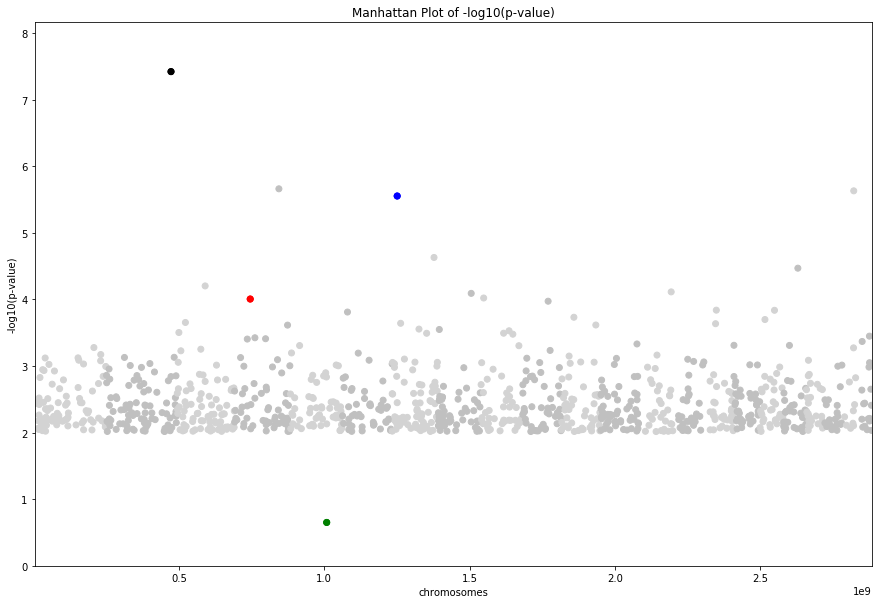

In [19]:
Manhattan(pd_wald, 'va.rank.wald_log10', '-log10(p-value)')

# Manhattan Plot for VariantSpark Analysis

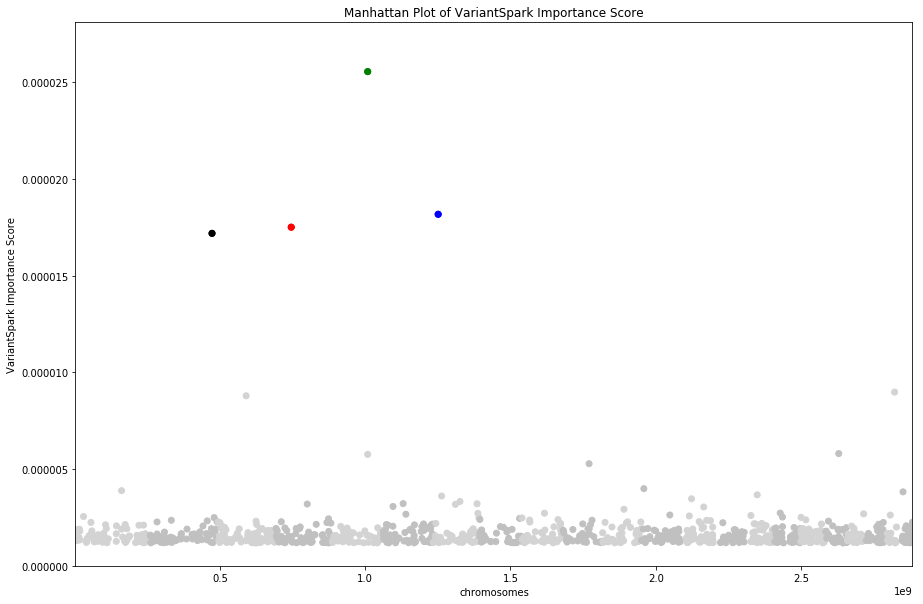

In [20]:
Manhattan(pd_vs, 'va.vsis', 'VariantSpark Importance Score')

In [21]:
nb_end = datetime.now()
print('Total Runtime: '+str(nb_end-nb_begin))

Total Runtime: 0:05:47.386610
